In [1]:
import numpy as np
import pandas as pd


X_train = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\X_train.npy', allow_pickle=True)
X_val = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\X_val.npy', allow_pickle=True)
X_test = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\X_test.npy', allow_pickle=True)
y_train = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\y_train.npy', allow_pickle=True)
y_val = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\y_val.npy', allow_pickle=True)
y_test = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\y_test.npy', allow_pickle=True)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
X_train[0]

(2208, 224, 224, 3) (2208, 15)
(736, 224, 224, 3) (736, 15)
(737, 224, 224, 3) (737, 15)


array([[[25, 25, 25],
        [21, 21, 21],
        [19, 19, 19],
        ...,
        [24, 24, 24],
        [24, 24, 24],
        [24, 24, 24]],

       [[26, 26, 26],
        [25, 25, 25],
        [25, 25, 25],
        ...,
        [33, 33, 33],
        [32, 32, 32],
        [33, 33, 33]],

       [[26, 26, 26],
        [25, 25, 25],
        [25, 25, 25],
        ...,
        [32, 32, 32],
        [33, 33, 33],
        [34, 34, 34]],

       ...,

       [[94, 94, 94],
        [77, 77, 77],
        [65, 65, 65],
        ...,
        [25, 25, 25],
        [25, 25, 25],
        [26, 26, 26]],

       [[87, 87, 87],
        [74, 74, 74],
        [63, 63, 63],
        ...,
        [23, 23, 23],
        [23, 23, 23],
        [24, 24, 24]],

       [[74, 74, 74],
        [69, 69, 69],
        [59, 59, 59],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [21, 21, 21]]], dtype=uint8)

In [2]:
# Convert images to float32 and scale to [0,1]
X_train = X_train.astype('float32') / 255.0
X_val   = X_val.astype('float32')   / 255.0
X_test  = X_test.astype('float32')  / 255.0

In [ ]:
import imgaug.augmenters as iaa
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define ALL augmentations in ONE line!
augmenter = iaa.Sequential([
    # Gaussian noise
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
    
    # Rotation (±15 degrees)
    iaa.Affine(rotate=(-15, 15)),
    
    # Perspective transformation
    iaa.PerspectiveTransform(scale=(0.01, 0.1)),
    
    # Histogram equalization
    iaa.AllChannelsHistogramEqualization(),
    
    # You can add more easily!
    iaa.Fliplr(0.5),  # 50% chance horizontal flip
    iaa.GaussianBlur(sigma=(0, 1.0))  # Random blur
])

In [ ]:


def augment_generator(X, y, batch_size=32):
    """Yields augmented batches indefinitely"""
    n = len(X)
    while True:
        idx = np.random.choice(n, batch_size, replace=False)
        batch_X = X[idx]

        # convert to uint8 for imgaug
        batch_X_uint8 = (batch_X * 255).astype(np.uint8)
        
        # apply augmentations in one go
        batch_X_aug = augmenter(images=batch_X_uint8)
        
        # back to float32 [0,1]
        batch_X_aug = np.array(batch_X_aug, dtype=np.float32) / 255.0

        yield batch_X_aug, y[idx]

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

NUM_CLASSES = len(y_train[0])

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [11]:
#  model build

base_cnn = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_cnn.trainable = True
for layer in base_cnn.layers[:-50]:
    layer.trainable = False

# model creation

model = models.Sequential([
    base_cnn,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(521, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

# Use SigmoidFocalCrossEntropy from TensorFlow Addons
focal_loss = tfa.losses.SigmoidFocalCrossEntropy(
    alpha=0.25,  # Balance factor for class imbalance
    gamma=2.0    # Focusing parameter to reduce easy examples contribution
)

model.compile(
    optimizer= optimizers.Adam(learning_rate=1e-5),
    loss= focal_loss,
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc', multi_label=True),
             tf.keras.metrics.AUC(name='auc_per_class', multi_label=True, curve='ROC')
             ]
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 521)               534025    
                                                                 
 dropout_1 (Dropout)         (None, 521)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               133632    
                                                      

In [12]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, verbose=1, monitor='val_auc'),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-7, verbose=1, monitor='val_auc'),
    ModelCheckpoint('best_densenet_focal_model.h5', save_best_only=True, verbose=1, monitor='val_auc'),
    CSVLogger('training_log_focal.csv')
]

In [13]:
batch_size = 32
steps_per_epoch = len(X_train) // batch_size

history = model.fit(
    augment_generator(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=20,
    steps_per_epoch=steps_per_epoch
)


Epoch 1/20


69/69 [==============================] - 280s 4s/step - loss: 3.3455 - accuracy: 0.1028 - precision: 0.1091 - recall: 0.4841 - auc: 0.5130 - auc_per_class: 0.5130 - val_loss: 0.8026 - val_accuracy: 0.1766 - val_precision: 0.1864 - val_recall: 0.2689 - val_auc: 0.5039 - val_auc_per_class: 0.5039
Epoch 2/20
69/69 [==============================] - 267s 4s/step - loss: 1.7233 - accuracy: 0.1291 - precision: 0.1317 - recall: 0.3409 - auc: 0.4978 - auc_per_class: 0.4978 - val_loss: 0.4237 - val_accuracy: 0.3601 - val_precision: 0.4231 - val_recall: 0.0746 - val_auc: 0.5121 - val_auc_per_class: 0.5121
Epoch 3/20
69/69 [==============================] - 263s 4s/step - loss: 1.2276 - accuracy: 0.1662 - precision: 0.1551 - recall: 0.2688 - auc: 0.5234 - auc_per_class: 0.5234 - val_loss: 0.3477 - val_accuracy: 0.4851 - val_precision: 0.4821 - val_recall: 0.0305 - val_auc: 0.5071 - val_auc_per_class: 0.5071
Epoch 4/20
69/69 [==============================] - 261s 4s/step - loss: 0.96

In [16]:
# ================== Evaluate ==================
test_loss, test_accuracy, test_precision, test_recall, test_auc , test_auc_per_class= model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test AUC per class: {test_auc_per_class:.4f}")

24/24 [==============================] - 46s 2s/step - loss: 0.3331 - accuracy: 0.5645 - precision: 0.6562 - recall: 0.0469 - auc: 0.5708 - auc_per_class: 0.5708
Test Loss: 0.3331
Test Accuracy: 0.5645
Test Precision: 0.6562
Test Recall: 0.0469
Test AUC: 0.5708
Test AUC per class: 0.5708


In [17]:
import joblib

mlb = joblib.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\multilabel_binarizer.pkl')

y_pred = model.predict(X_test, verbose=0)
y_pred_binary = (y_pred > 0.3).astype(int) 

# Classification report
from sklearn.metrics import classification_report
print("\n CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_binary, target_names=mlb.classes_, zero_division=0))


 CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00        64
      Cardiomegaly       0.00      0.00      0.00        27
     Consolidation       0.00      0.00      0.00        27
             Edema       0.00      0.00      0.00         9
          Effusion       0.00      0.00      0.00        69
         Emphysema       0.00      0.00      0.00        15
          Fibrosis       0.00      0.00      0.00        30
           Healthy       0.57      1.00      0.72       416
            Hernia       0.00      0.00      0.00         3
      Infiltration       0.20      0.02      0.03       131
              Mass       0.00      0.00      0.00        15
            Nodule       0.00      0.00      0.00        39
Pleural_Thickening       0.00      0.00      0.00        24
         Pneumonia       0.00      0.00      0.00         8
      Pneumothorax       0.00      0.00      0.00        18

         micr

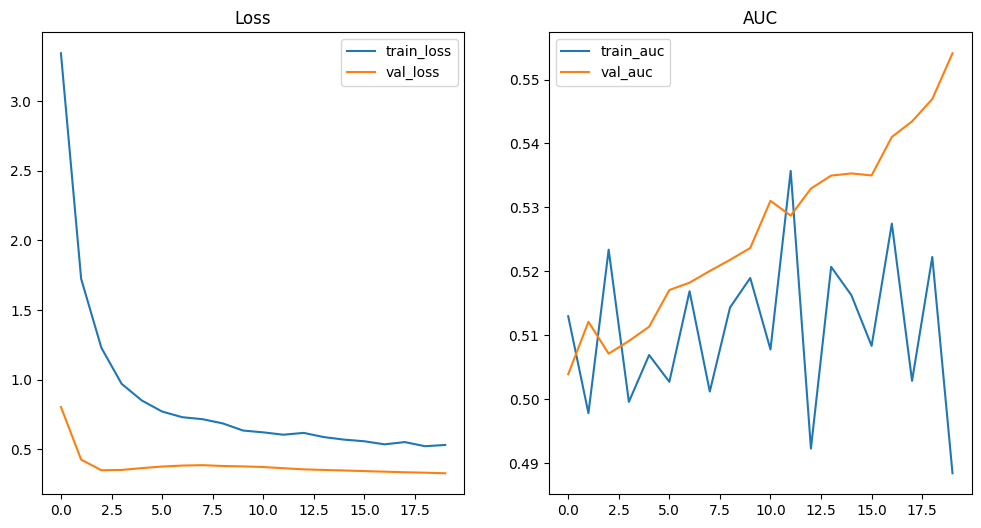

In [22]:
import matplotlib.pyplot as plt

# ================== Plot Training Curves ==================
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.legend()
plt.title("AUC")

plt.savefig(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\curves\pretrained_training_curves.png')
plt.show()

In [19]:
# Save the final model
model.save(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\augmented_model.h5')
print("💾 Model saved as 'chest_xray_final_model.h5'")

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


💾 Model saved as 'chest_xray_final_model.h5'


In [20]:

# Save training history
np.save(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\augmented_training_history.npy', history.history)
print("💾 Training history saved")

💾 Training history saved
